In [1]:
# 1) Wipe out all Python variables
%reset -f
# 2) Force Python’s garbage collector to run
import gc
gc.collect()

import importlib
from libs import trades, plots, params, models
importlib.reload(trades)
importlib.reload(plots)
importlib.reload(params)
importlib.reload(models)

import sys
print(sys.executable)

import math
import pandas as pd
from pandas import Timestamp
import numpy as np
import glob
import os
import datetime as dt
from datetime import datetime
from pprint import pprint
from collections import OrderedDict

import matplotlib.pyplot as plt
import plotly.graph_objects as go
from IPython.display import display, HTML
import seaborn as sns

from typing import Optional, Dict, Tuple, List, Sequence
from sklearn.preprocessing import StandardScaler

from tqdm.auto import tqdm
tqdm.pandas()        

pd.set_option('display.max_columns', None)



/usr/bin/python


[main] Found existing base CSV: dfs_training/AAPL_1_base.csv


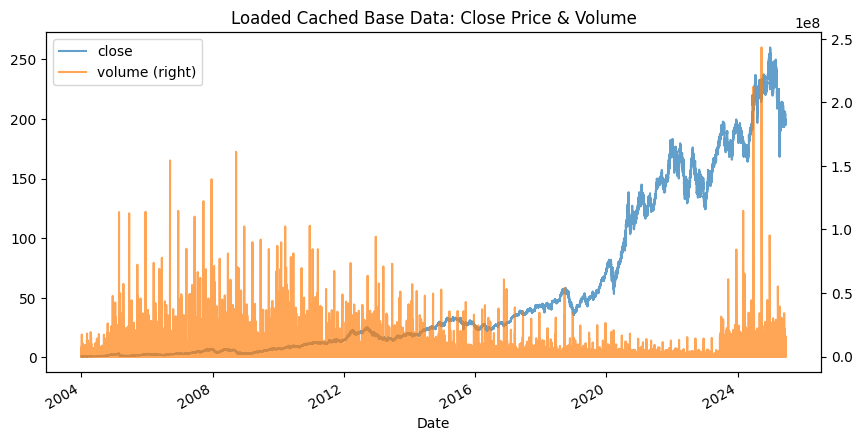

open        high         low       close  \
2004-01-02 11:30:00    0.764286    0.764286    0.764286    0.764286   
2004-01-02 11:31:00    0.764286    0.764286    0.764286    0.764286   
2004-01-02 11:32:00    0.764286    0.764286    0.764286    0.764286   
2004-01-02 11:33:00    0.764286    0.764286    0.764286    0.764286   
2004-01-02 11:34:00    0.764286    0.764286    0.764286    0.764286   
...                         ...         ...         ...         ...   
2025-06-18 20:56:00  196.680000  196.860000  196.630000  196.815000   
2025-06-18 20:57:00  196.810000  196.940000  196.560000  196.675000   
2025-06-18 20:58:00  196.675000  196.740000  196.630000  196.670000   
2025-06-18 20:59:00  196.680000  196.750000  196.240000  196.240000   
2025-06-18 21:00:00  196.580000  196.650000  196.080000  196.540000   

                         volume         ask         bid  
2004-01-02 11:30:00     28000.0    0.764514    0.764057  
2004-01-02 11:31:00     28000.0    0.764514    0.764057  
2004-01-02 11:32:00     28000.0    0.764514    0.764057  
2004-01-02 11:33:00     28000.0    0.764514    0.764057  
2004-01-02 11:34:00     28000.0    0.764514    0.764057  
...                         ...         ...         ...  
2025-06-18 20:56:00    385695.0  196.874000  196.756000  
2025-06-18 20:57:00    460630.0  196.734000  196.616000  
2025-06-18 20:58:00    525245.0  196.729000  196.611000  
2025-06-18 20:59:00   2075503.0  196.298900  196.181100  
2025-06-18 21:00:00  15600625.0  196.599000  196.481000  

[3083400 rows x 7 columns]

In [2]:
ticker = params.ticker
month_to_plot = params.date_to_test # just used if date_to_check = None
date_to_check = params.date_to_check 
base_csv = params.base_csv

if os.path.exists(base_csv):
    # -----------------------------------------------------------------
    # 1) Cached file exists → load it, plot it, skip all processing.
    # -----------------------------------------------------------------
    print(f"[main] Found existing base CSV: {base_csv}")
    df = pd.read_csv(base_csv, index_col=0, parse_dates=True)
    plots.plot_close_volume(
        df,
        title="Loaded Cached Base Data: Close Price & Volume"
    )

else:
    # -----------------------------------------------------------------
    # 2) No cached file → do the full split‐adjust and then minute‐grid prep
    # -----------------------------------------------------------------
    print(f"[main] No base CSV found; running process_splits …")
    df_raw = trades.process_splits(
        folder                   = params.stocks_folder,
        ticker                   = ticker,
        bidasktoclose_spread     = params.bidasktoclose_spread
    )

    # Once‐only minute grid build and interpolation
    print(f"[main] Running prepare_interpolate_data …")
    df = trades.prepare_interpolate_data(
        df                    = df_raw,
        regular_start_shifted = params.regular_start_shifted,
        regular_start         = params.regular_start,
        regular_end           = params.regular_end
    )
    
    # Persist to base CSV and return
    df.to_csv(base_csv)
    print(f"[process_splits] Saved processed data to: {base_csv}")

# df is now guaranteed to be the split‐adjusted, minute‐aligned DataFrame
df


In [3]:
global_ref  = trades.compute_global_ref_profit(df = df)
global_ref # reference median used to scale the signal

0.0027165092857713187

In [4]:
def process_single_day(day_str, buy_threshold): 
    # Processes one calendar day, called by the function 'saveDF_checkDAY'
    print(f"\n=== Processing trading day {day_str} ===")
    day_dt = pd.to_datetime(day_str)
    day_df = df.loc[df.index.normalize() == day_dt].copy()
    if day_df.empty:
        print(" no data; skipping.")
        return
            
    print("\n Running trading pipeline on selected date …")
    result = trades.run_trading_pipeline(day_df, 
                                         col_signal='signal',
                                         col_action='signal_action',
                                         ref_profit=global_ref,
                                         day_to_check=day_str)
    
    if result is None:
        print(" no trades found; skipping.")
        return

    df_day, trades_day, perf_day = result
    plots.plot_trades(
        df=df_day,
        col_signal1='signal',
        col_signal2=False,
        col_action='signal_action',
        trades=trades_day,
        buy_threshold=buy_threshold,
        performance_stats=perf_day
    )

    print(f"\n=== Performance for {day_dt} ===")
    for k, v in perf_day.items():
        print(f"{k}: {v}")

    return df_day, perf_day


In [5]:
def saveDF_checkDAY(
    df,
    ticker,
    min_prof_thr,
    max_down_prop,
    gain_tightening_factor,
    smooth_win_sig,
    pre_entry_decay,
    buy_threshold,
    trailing_stop_thresh,
    merging_retracement_thr,
    merging_time_gap_thr,
    keep_cols=None,
    date_to_check=None
):
    """
    Modes:
      • Month ('YYYY-MM')   → process each day, then summary  
      • Day   ('YYYY-MM-DD')→ process that day only  
      • None  → full‐run: smooth ALL, pipeline, merge+interpolate w/ progress, save CSV  
    """
    if keep_cols is None:
        keep_cols = [
            "open","high","low","close","volume", "bid","ask",
            "StrategyEarning","EarningDiff", "signal_raw", "signal_smooth", "signal_action"
        ]

    if date_to_check:
        if len(date_to_check) == 7:
            # -------------------------------------------------------------------------
            # # Month mode: 'YYYY-MM'
            # -------------------------------------------------------------------------
            print(f"\nMonth mode: processing {date_to_check}")

            # 1) collect all days in this month
            dates_days = (
                df.loc[df.index.strftime("%Y-%m") == date_to_check]
                  .index.normalize()
                  .unique()
            )

            performance_list = []
            daily_frames     = []
            
            for date_day in sorted(dates_days.astype(str)):
                res = process_single_day(date_day, buy_threshold)
                if res is None:
                    continue
    
                df_day, perf_day = res
                daily_frames.append(df_day)       # collect the day’s DF
                performance_list.append(perf_day) # collect its stats
    
            if not daily_frames:
                print("No valid days in this month.")
                return
    
            # build the month‐DF from exactly those df_day’s
            df_month = pd.concat(daily_frames).sort_index()
            # print monthly performance summary
            plots.aggregate_performance(performance_list, df_month)

            return df_month
            
        else:
            # -------------------------------------------------------------------------
            # Single-day mode: 'YYYY-MM-DD'
            # -------------------------------------------------------------------------
            return process_single_day(date_to_check, buy_threshold)

    # -------------------------------------------------------------------------
    # Full mode: Processing all days and saving dataframe
    # -------------------------------------------------------------------------
    print(f"\nFull-run mode")
      
    print("\n•Running trading pipeline on full dataset …")
    full_sim_results = trades.run_trading_pipeline( 
        df,
        col_signal='signal_smooth',
        col_action='signal_action',
        ref_profit=global_ref,
        day_to_check=None
    )

    print("\n•Merging, concatenating all days, and calculating test performances …")
    daily_frames    = [res[0][keep_cols] for res in full_sim_results.values()]
    df_all          = pd.concat(daily_frames).sort_index()
    performance_all = [res[2] for res in full_sim_results.values()]
    plots.aggregate_performance(performance_all, df_all)
    days_all = df_all.index.normalize().unique()

    # prepare the performances summary just for the test days
    cutoff   = int(len(days_all) * (params.train_prop + params.val_prop))
    test_days = days_all[cutoff:][1:]   # to use the same test days as in the model test prediction
    df_test = df_all[ df_all.index.normalize().isin(test_days) ]
    performance_test = [perf
                        for day, (_,_,perf) in full_sim_results.items()
                        if pd.Timestamp(day).normalize() in test_days]
    plots.aggregate_performance(performance_test, df_test)    

    print("\n•Saving CSV …")
    ready_csv = params.ready_csv
    df_all.to_csv(ready_csv)
    print(f"Saved to {ready_csv}")

    return df_all




Month mode: processing 2004-03

=== Processing trading day 2004-03-01 ===

 Running trading pipeline on selected date …
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


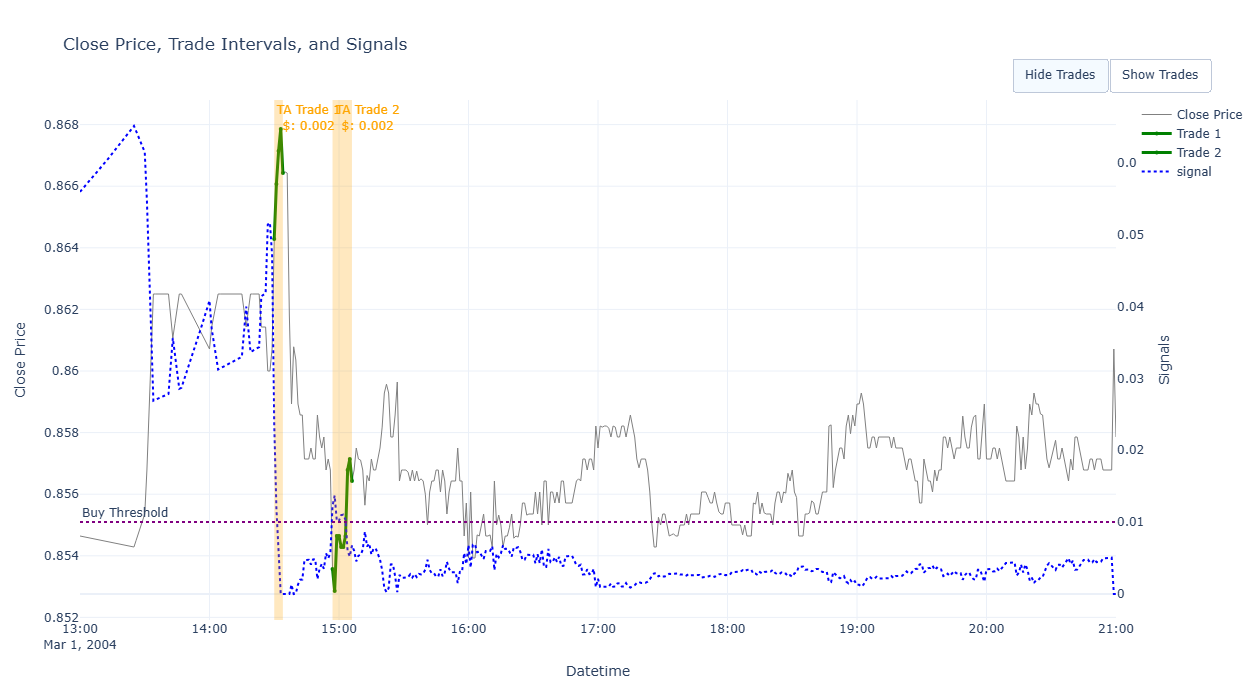


=== Performance for 2004-03-01 00:00:00 ===
Buy & Hold Return ($): -0.007
Strategy Return ($): 0.004
Trades Returns ($): [0.002, 0.002]

=== Processing trading day 2004-03-02 ===

 Running trading pipeline on selected date …
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


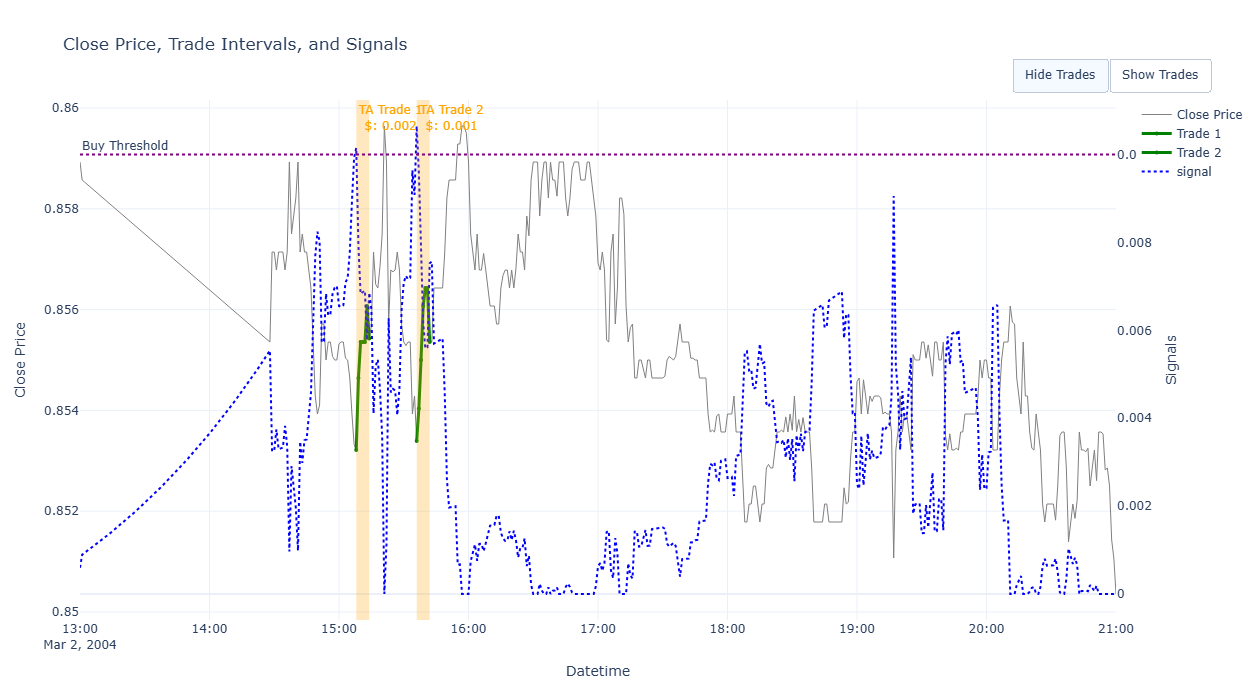


=== Performance for 2004-03-02 00:00:00 ===
Buy & Hold Return ($): -0.007
Strategy Return ($): 0.003
Trades Returns ($): [0.002, 0.001]

=== Processing trading day 2004-03-03 ===

 Running trading pipeline on selected date …
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


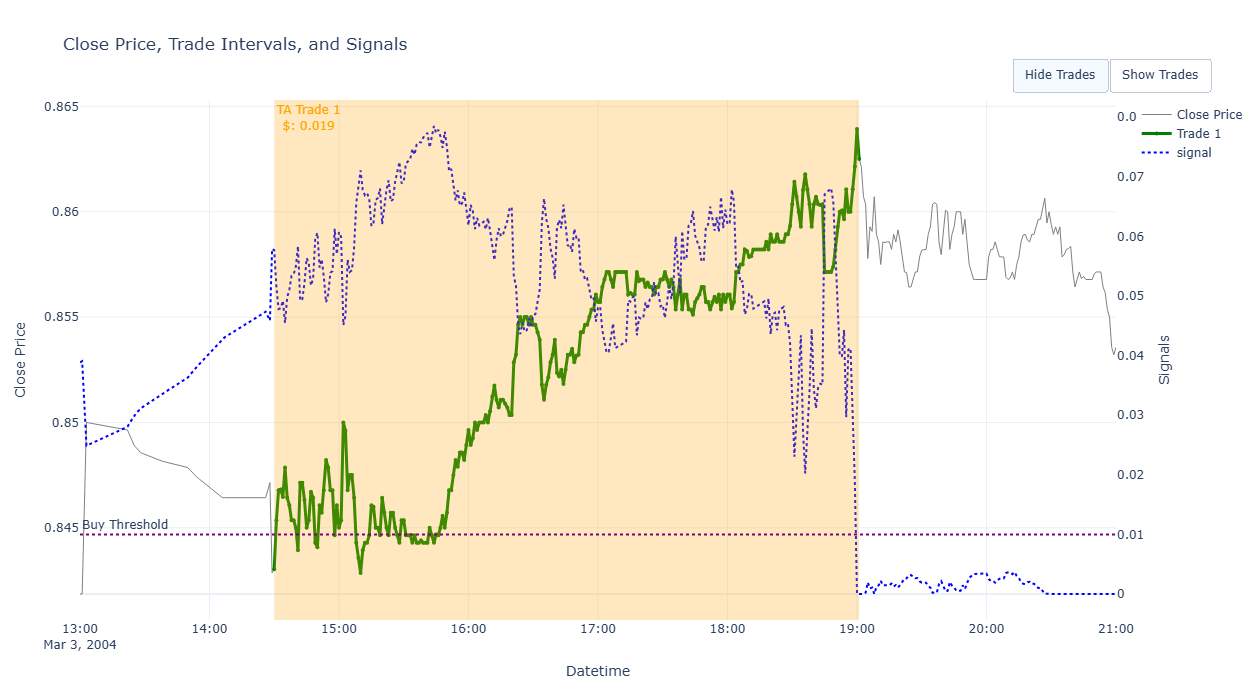


=== Performance for 2004-03-03 00:00:00 ===
Buy & Hold Return ($): 0.01
Strategy Return ($): 0.019
Trades Returns ($): [0.019]

=== Processing trading day 2004-03-04 ===

 Running trading pipeline on selected date …
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


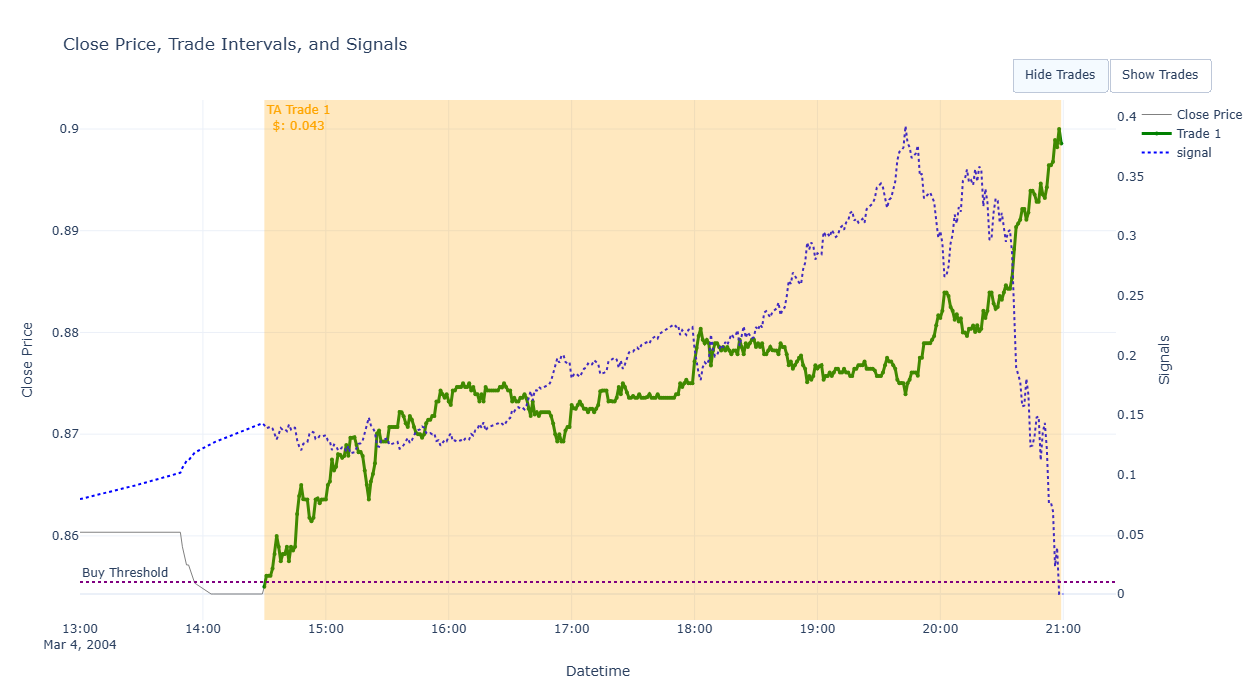


=== Performance for 2004-03-04 00:00:00 ===
Buy & Hold Return ($): 0.043
Strategy Return ($): 0.043
Trades Returns ($): [0.043]

=== Processing trading day 2004-03-05 ===

 Running trading pipeline on selected date …
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


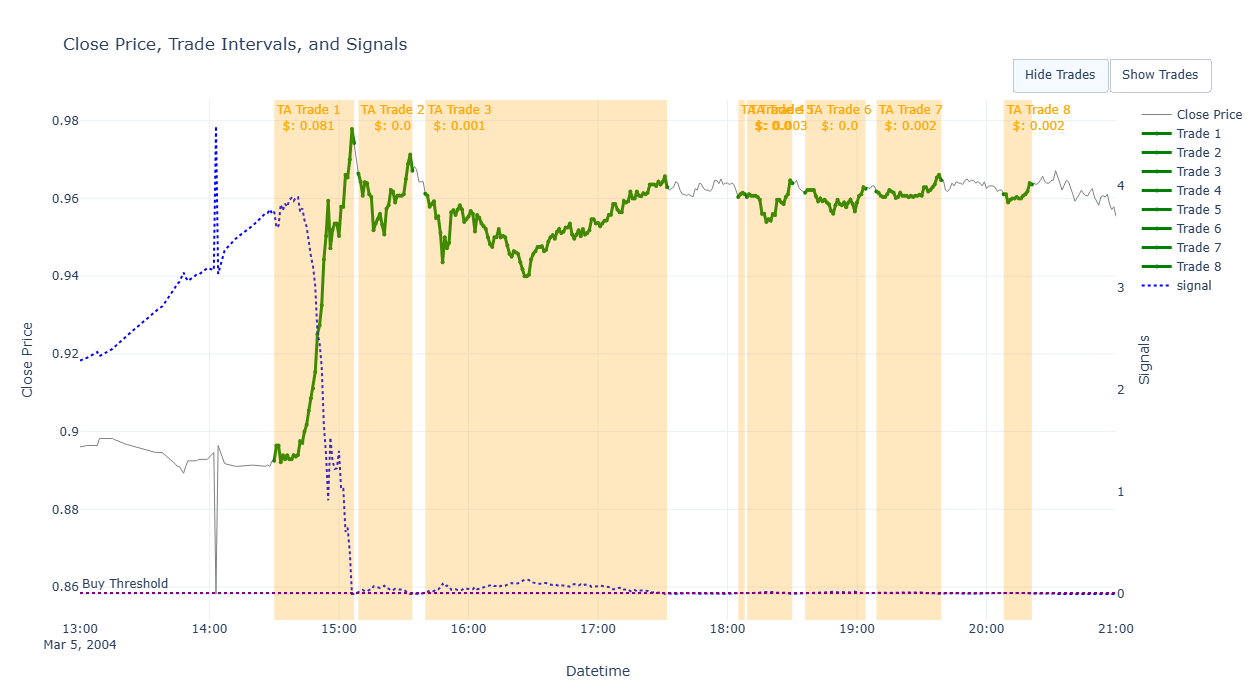


=== Performance for 2004-03-05 00:00:00 ===
Buy & Hold Return ($): 0.062
Strategy Return ($): 0.09
Trades Returns ($): [0.081, 0.0, 0.001, 0.0, 0.003, 0.0, 0.002, 0.002]

=== Processing trading day 2004-03-08 ===

 Running trading pipeline on selected date …
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


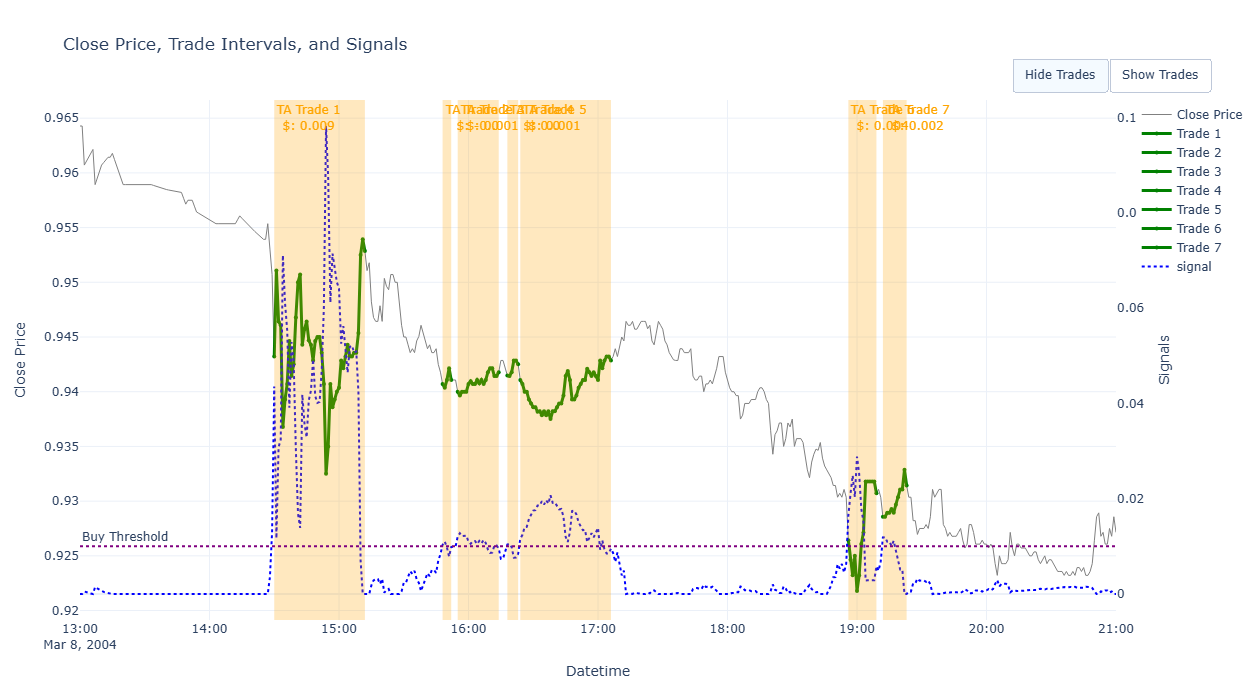


=== Performance for 2004-03-08 00:00:00 ===
Buy & Hold Return ($): -0.017
Strategy Return ($): 0.018
Trades Returns ($): [0.009, -0.0, 0.001, 0.0, 0.001, 0.004, 0.002]

=== Processing trading day 2004-03-09 ===

 Running trading pipeline on selected date …
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


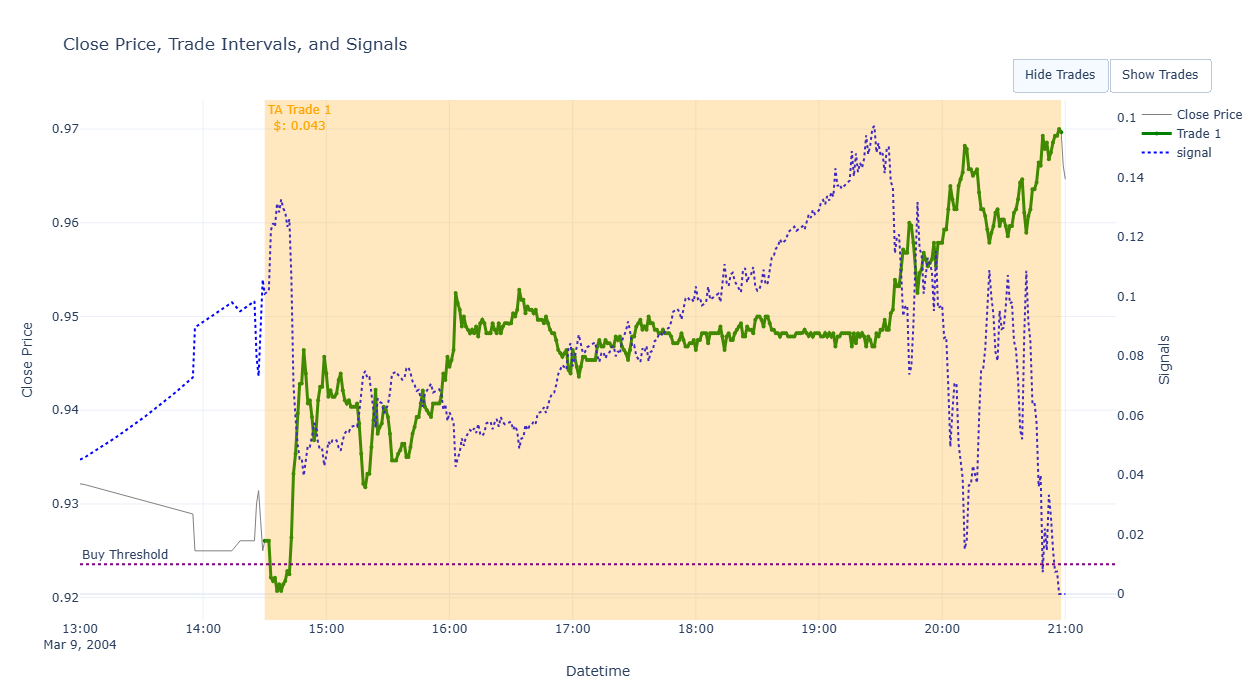


=== Performance for 2004-03-09 00:00:00 ===
Buy & Hold Return ($): 0.038
Strategy Return ($): 0.043
Trades Returns ($): [0.043]

=== Processing trading day 2004-03-10 ===

 Running trading pipeline on selected date …
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


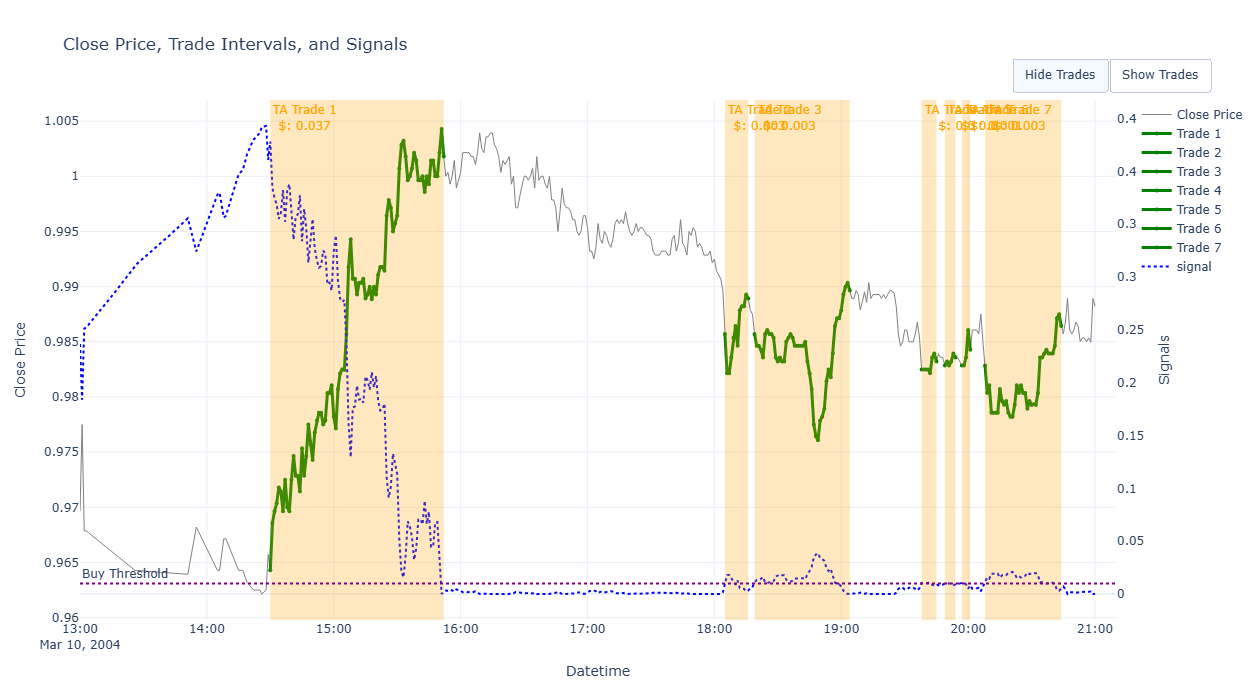


=== Performance for 2004-03-10 00:00:00 ===
Buy & Hold Return ($): 0.023
Strategy Return ($): 0.047
Trades Returns ($): [0.037, 0.003, 0.003, 0.0, 0.0, 0.001, 0.003]

=== Processing trading day 2004-03-11 ===

 Running trading pipeline on selected date …
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


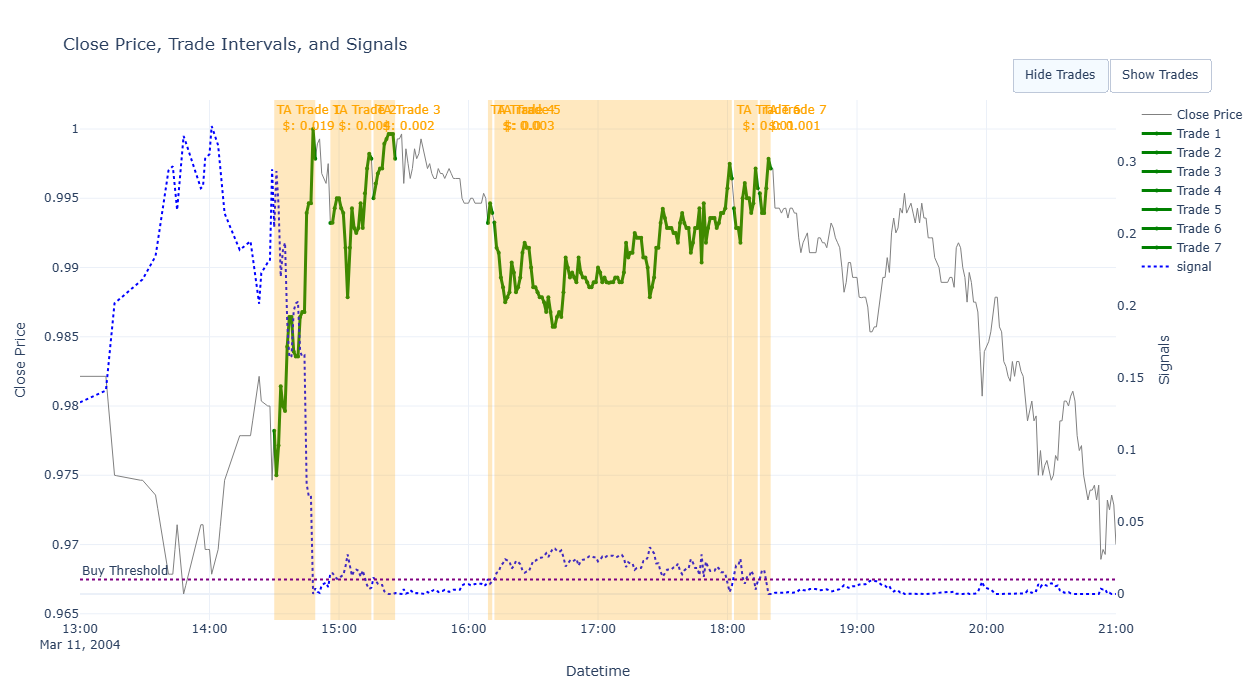


=== Performance for 2004-03-11 00:00:00 ===
Buy & Hold Return ($): -0.009
Strategy Return ($): 0.03
Trades Returns ($): [0.019, 0.004, 0.002, 0.0, 0.003, 0.001, 0.001]

=== Processing trading day 2004-03-12 ===

 Running trading pipeline on selected date …
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


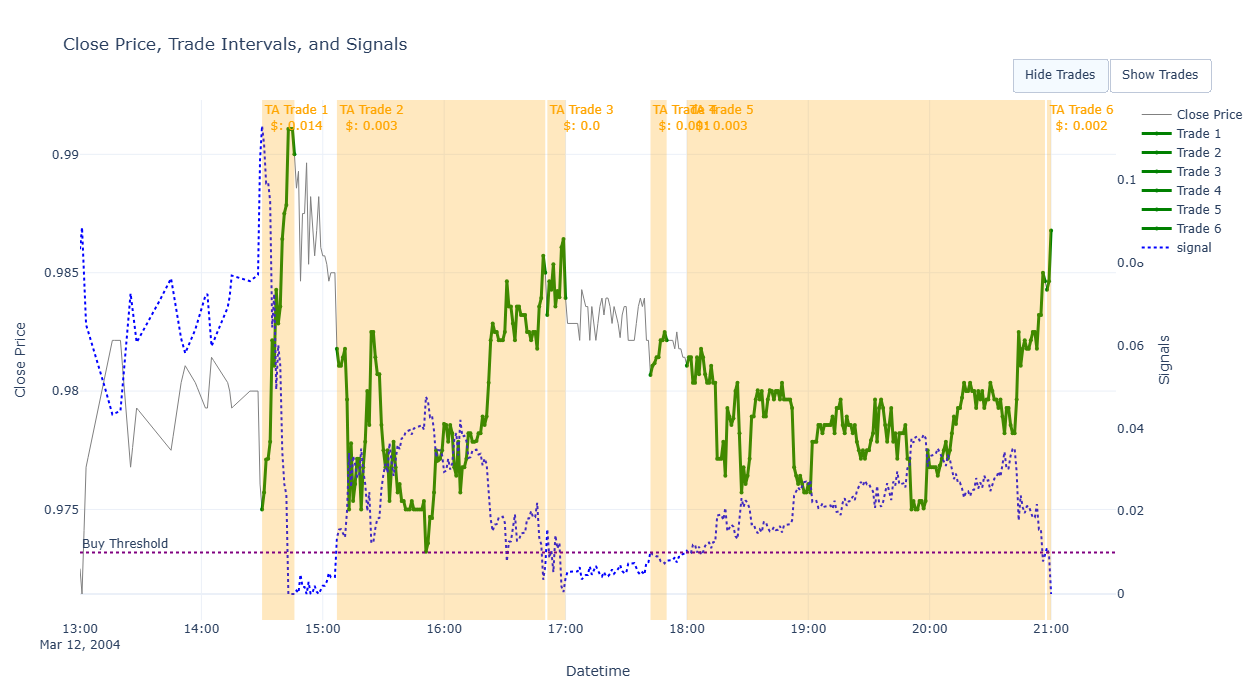


=== Performance for 2004-03-12 00:00:00 ===
Buy & Hold Return ($): 0.011
Strategy Return ($): 0.023
Trades Returns ($): [0.014, 0.003, 0.0, 0.001, 0.003, 0.002]

=== Processing trading day 2004-03-15 ===

 Running trading pipeline on selected date …
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


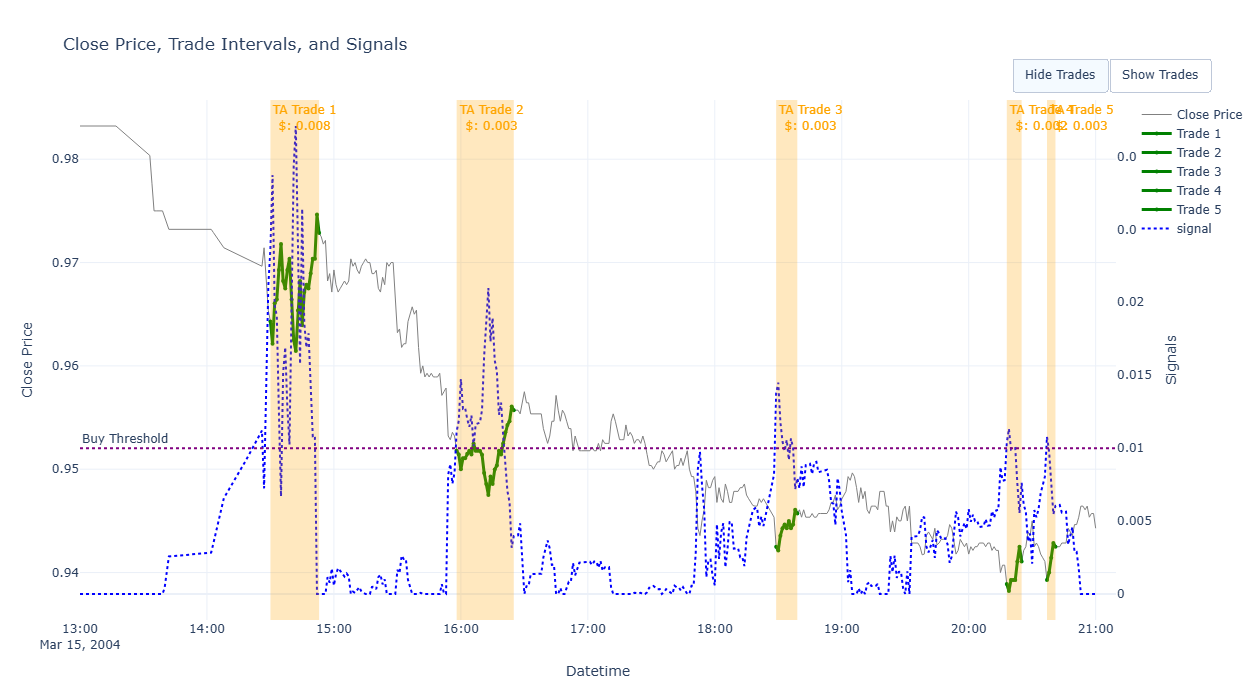


=== Performance for 2004-03-15 00:00:00 ===
Buy & Hold Return ($): -0.021
Strategy Return ($): 0.018
Trades Returns ($): [0.008, 0.003, 0.003, 0.002, 0.003]

=== Processing trading day 2004-03-16 ===

 Running trading pipeline on selected date …
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


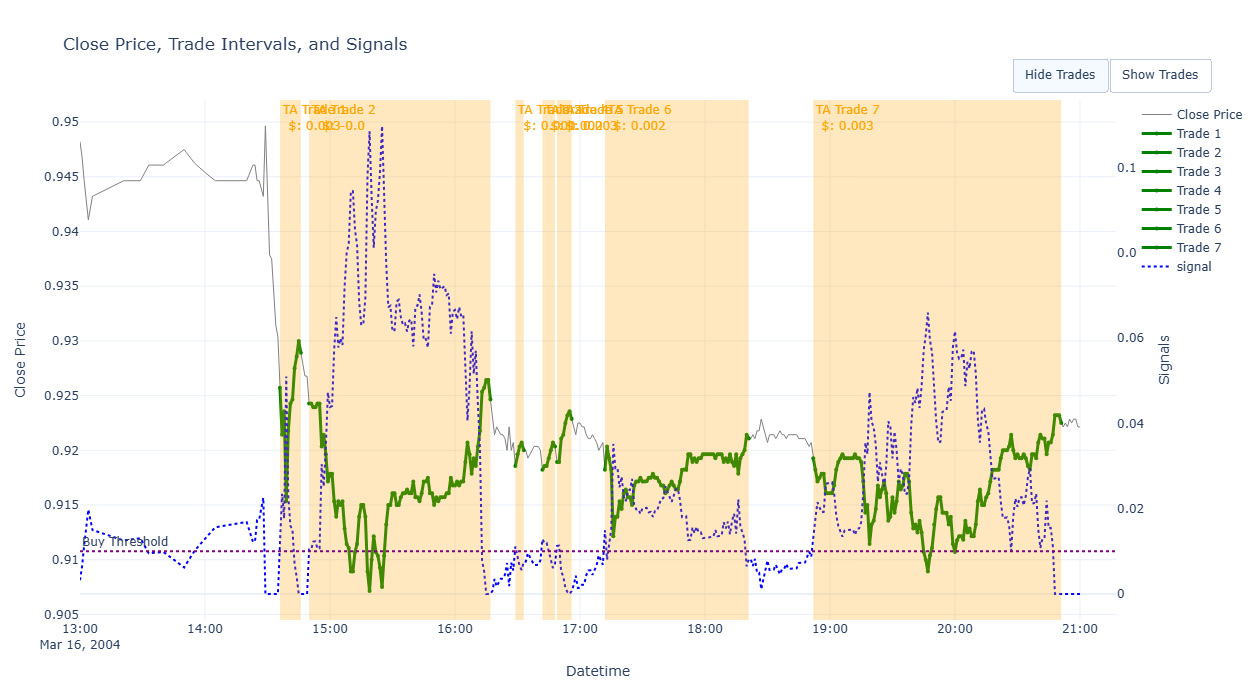


=== Performance for 2004-03-16 00:00:00 ===
Buy & Hold Return ($): -0.021
Strategy Return ($): 0.013
Trades Returns ($): [0.003, -0.0, 0.001, 0.002, 0.003, 0.002, 0.003]

=== Processing trading day 2004-03-17 ===

 Running trading pipeline on selected date …
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


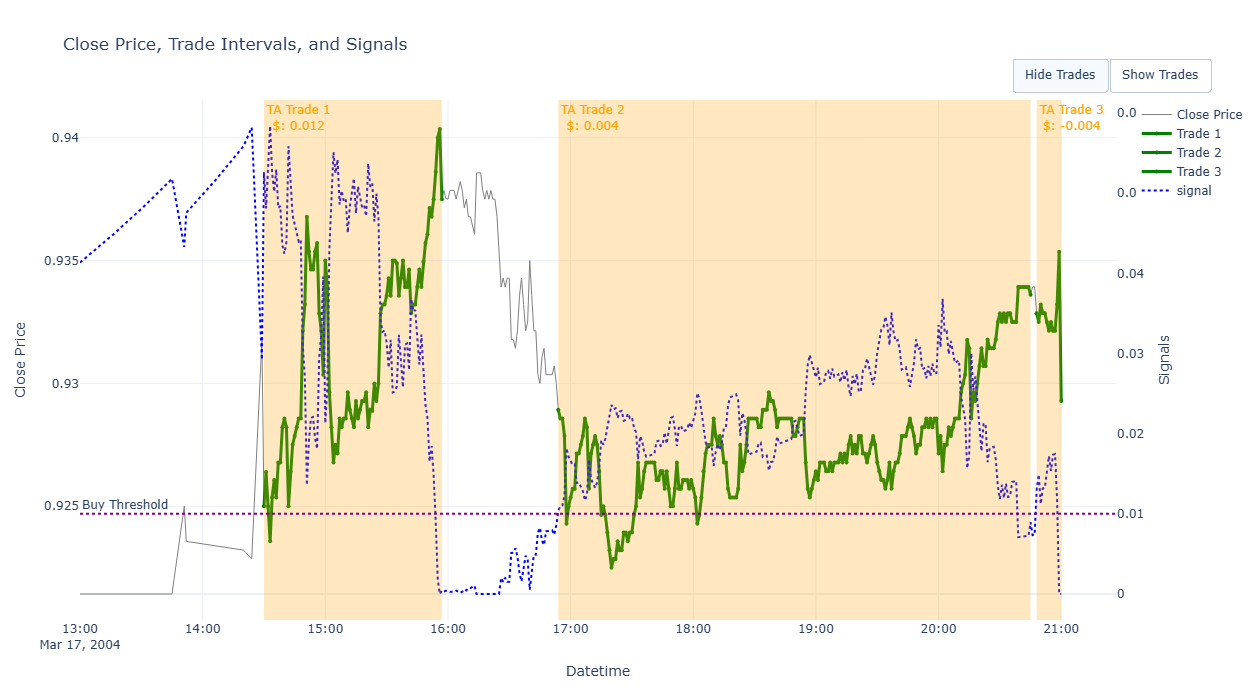


=== Performance for 2004-03-17 00:00:00 ===
Buy & Hold Return ($): 0.004
Strategy Return ($): 0.012
Trades Returns ($): [0.012, 0.004, -0.004]

=== Processing trading day 2004-03-18 ===

 Running trading pipeline on selected date …
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


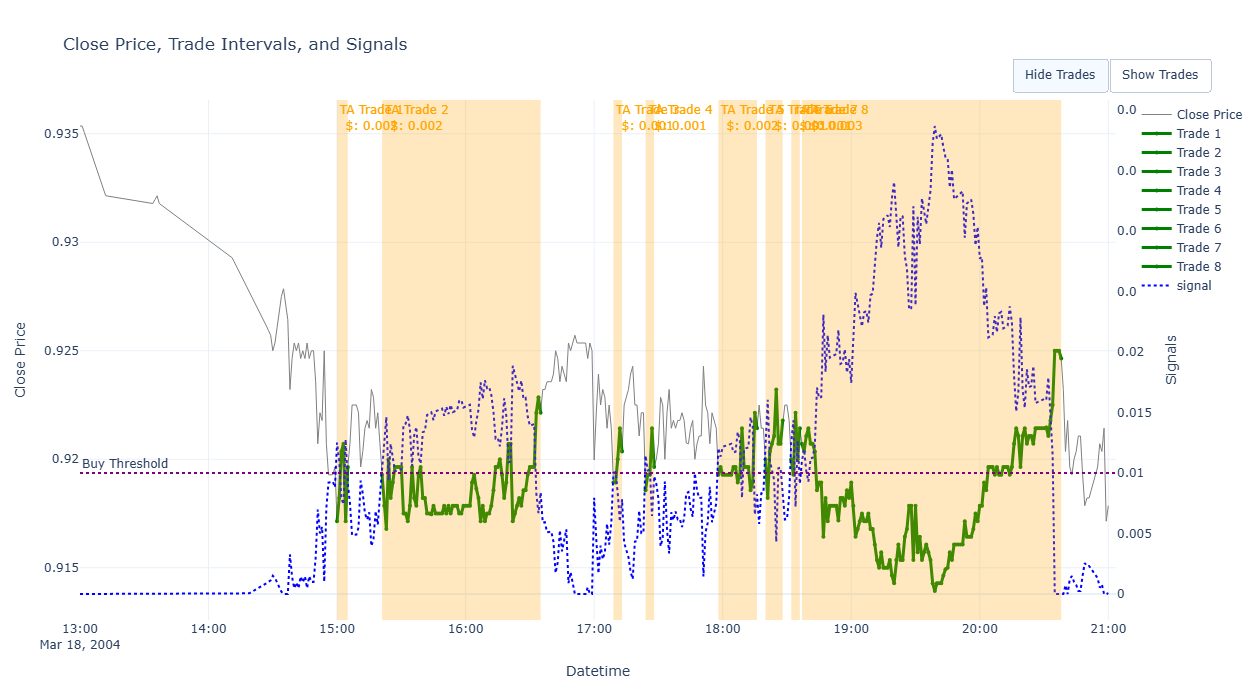


=== Performance for 2004-03-18 00:00:00 ===
Buy & Hold Return ($): -0.008
Strategy Return ($): 0.013
Trades Returns ($): [0.002, 0.002, 0.001, 0.001, 0.002, 0.001, 0.001, 0.003]

=== Processing trading day 2004-03-19 ===

 Running trading pipeline on selected date …
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


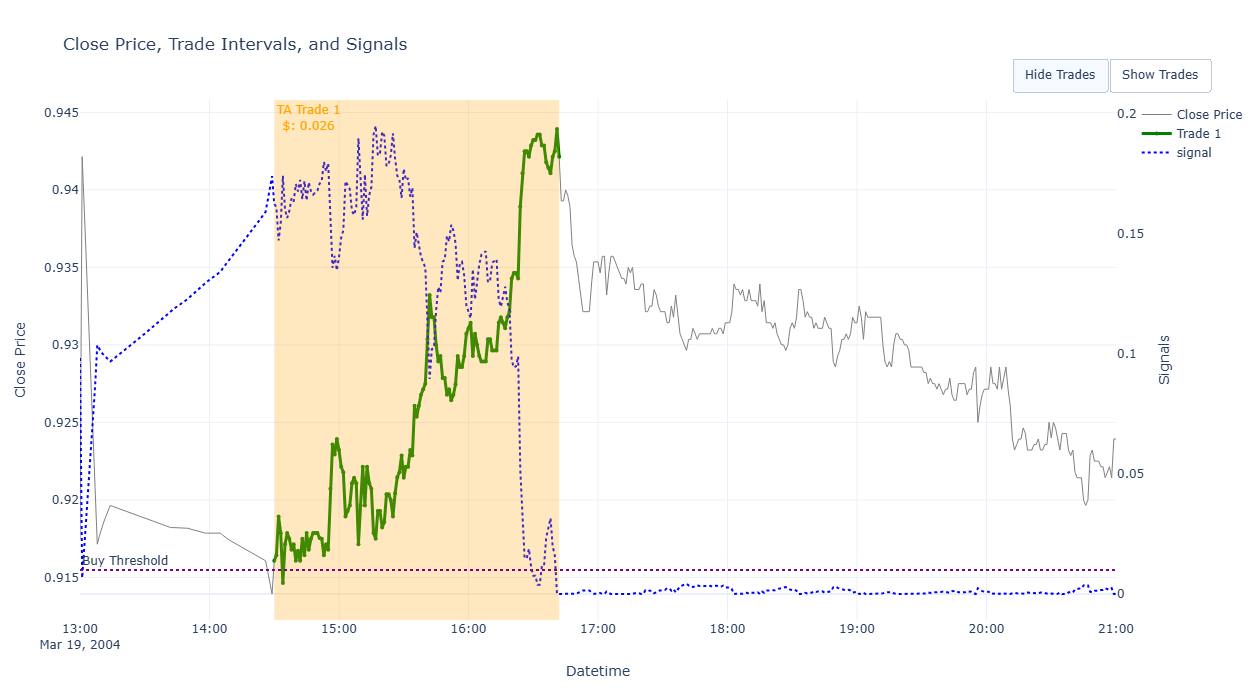


=== Performance for 2004-03-19 00:00:00 ===
Buy & Hold Return ($): 0.007
Strategy Return ($): 0.026
Trades Returns ($): [0.026]

=== Processing trading day 2004-03-22 ===

 Running trading pipeline on selected date …
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


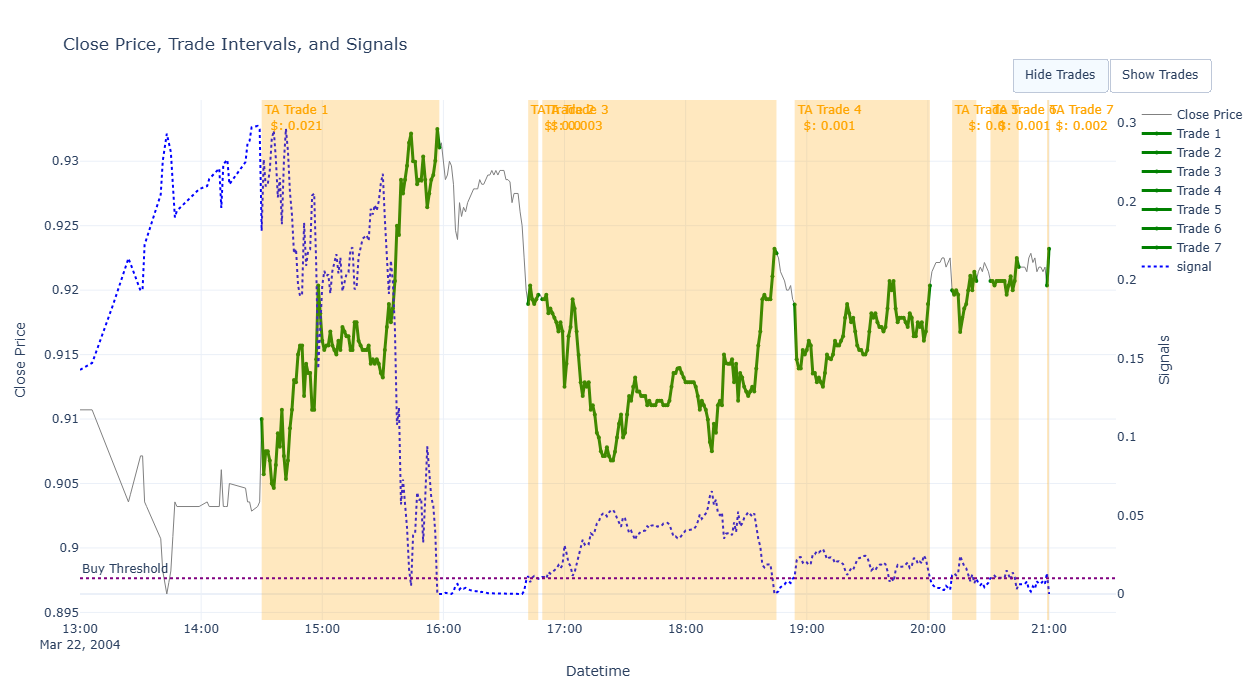


=== Performance for 2004-03-22 00:00:00 ===
Buy & Hold Return ($): 0.013
Strategy Return ($): 0.028
Trades Returns ($): [0.021, 0.0, 0.003, 0.001, 0.0, 0.001, 0.002]

=== Processing trading day 2004-03-23 ===

 Running trading pipeline on selected date …
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


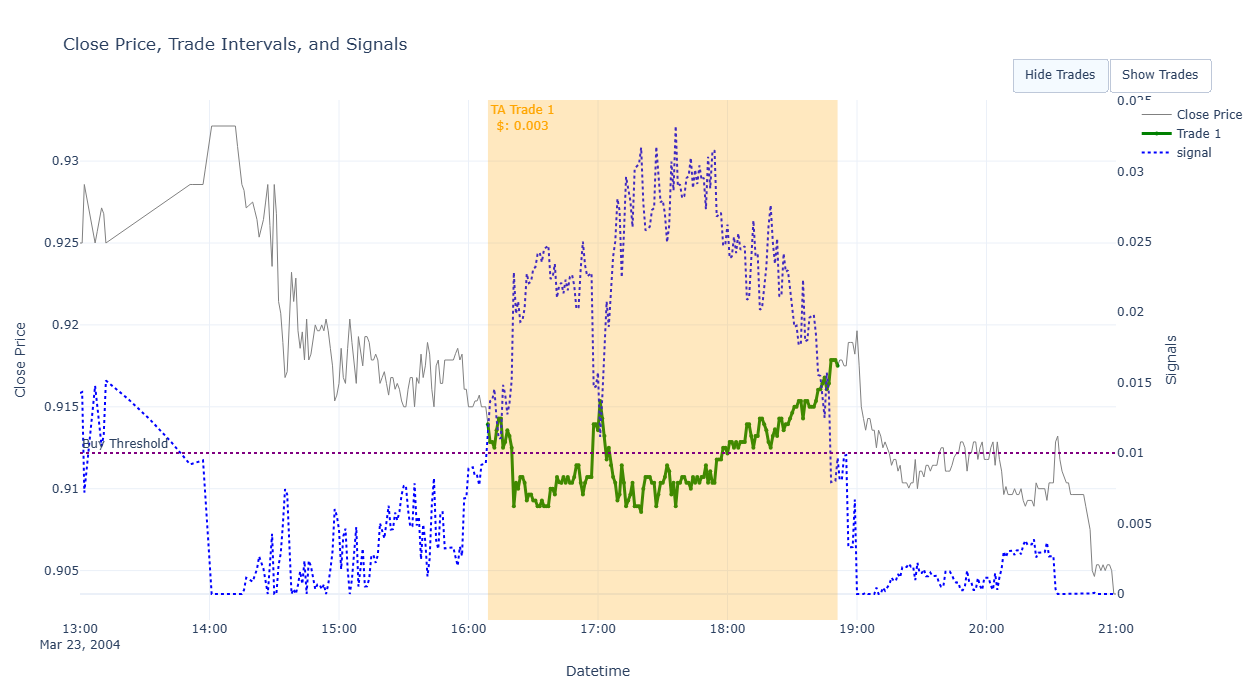


=== Performance for 2004-03-23 00:00:00 ===
Buy & Hold Return ($): -0.026
Strategy Return ($): 0.003
Trades Returns ($): [0.003]

=== Processing trading day 2004-03-24 ===

 Running trading pipeline on selected date …
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


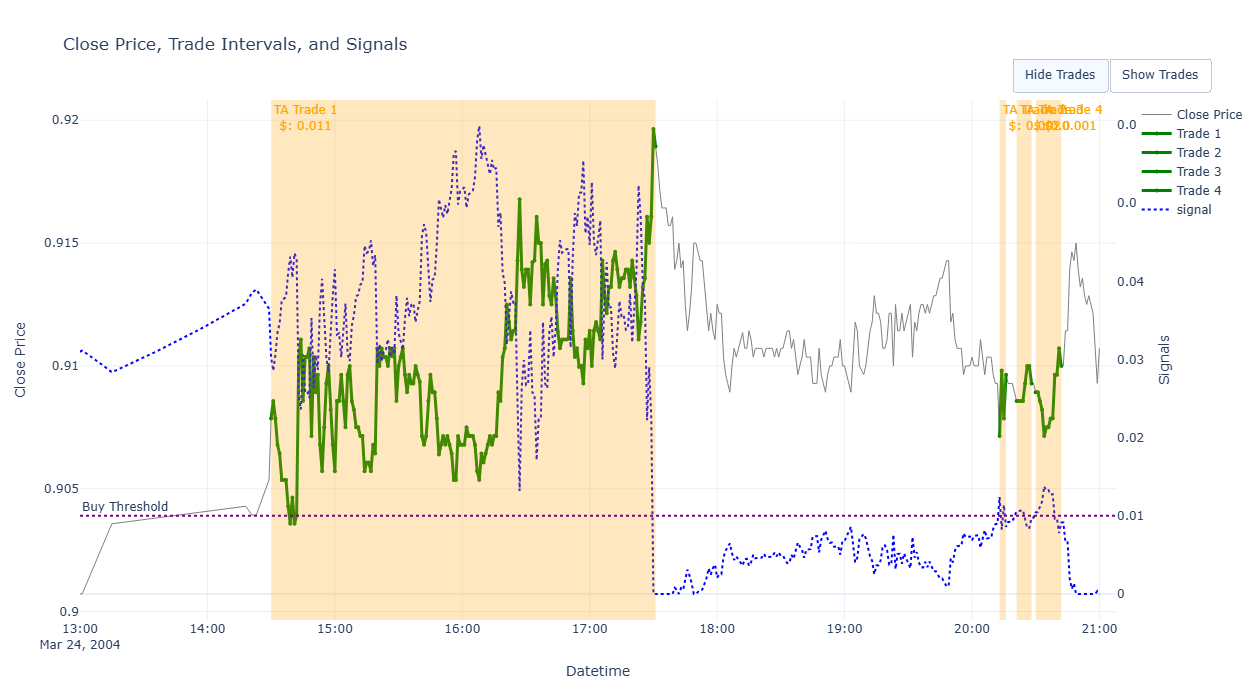


=== Performance for 2004-03-24 00:00:00 ===
Buy & Hold Return ($): 0.002
Strategy Return ($): 0.013
Trades Returns ($): [0.011, 0.002, 0.0, 0.001]

=== Processing trading day 2004-03-25 ===

 Running trading pipeline on selected date …
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


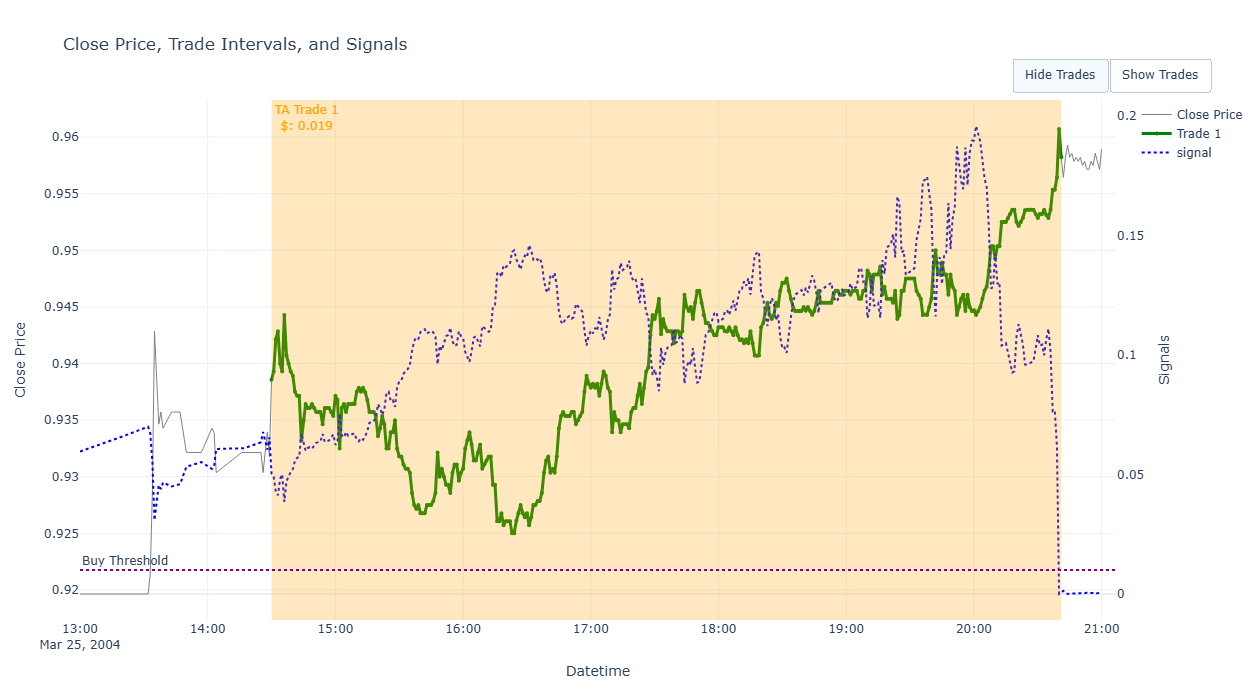


=== Performance for 2004-03-25 00:00:00 ===
Buy & Hold Return ($): 0.02
Strategy Return ($): 0.019
Trades Returns ($): [0.019]

=== Processing trading day 2004-03-26 ===

 Running trading pipeline on selected date …
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


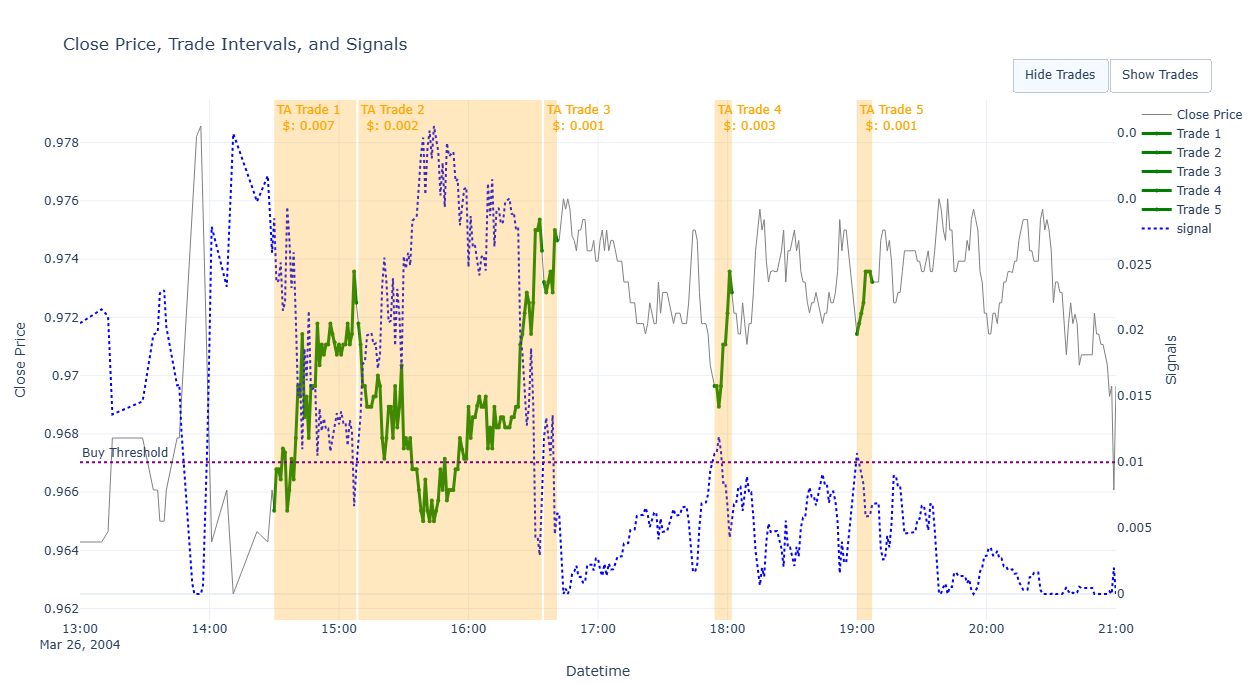


=== Performance for 2004-03-26 00:00:00 ===
Buy & Hold Return ($): 0.004
Strategy Return ($): 0.013
Trades Returns ($): [0.007, 0.002, 0.001, 0.003, 0.001]

=== Processing trading day 2004-03-29 ===

 Running trading pipeline on selected date …
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


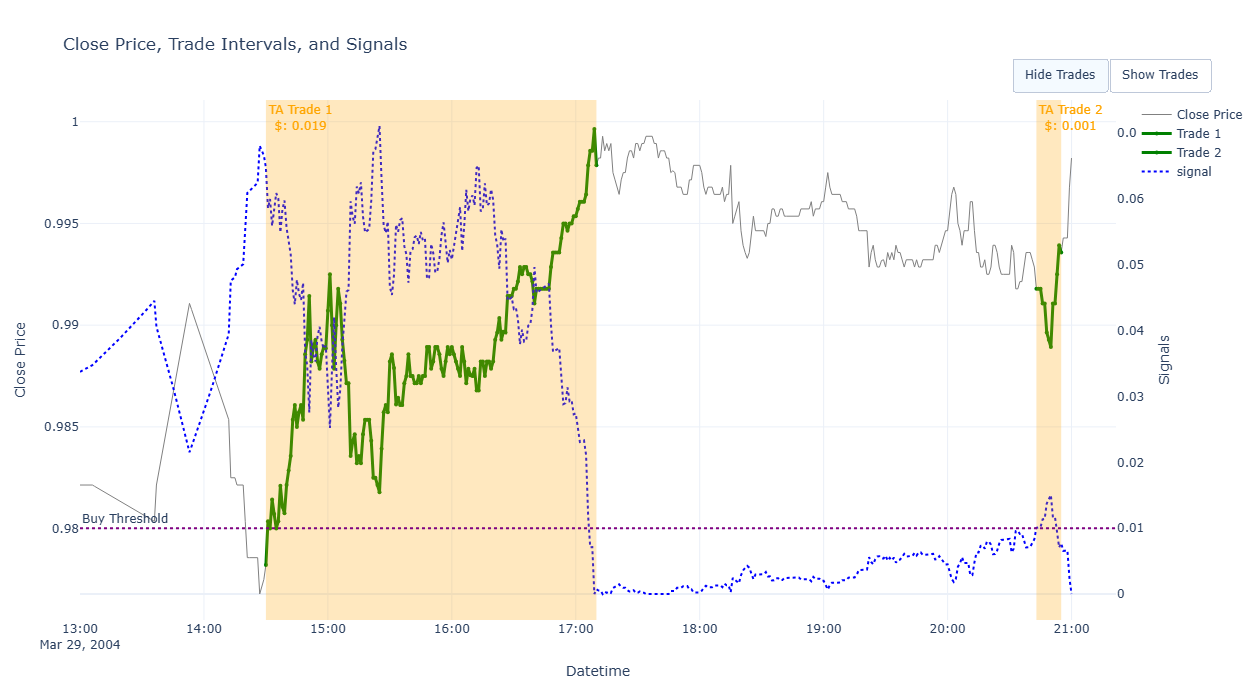


=== Performance for 2004-03-29 00:00:00 ===
Buy & Hold Return ($): 0.019
Strategy Return ($): 0.02
Trades Returns ($): [0.019, 0.001]

=== Processing trading day 2004-03-30 ===

 Running trading pipeline on selected date …
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


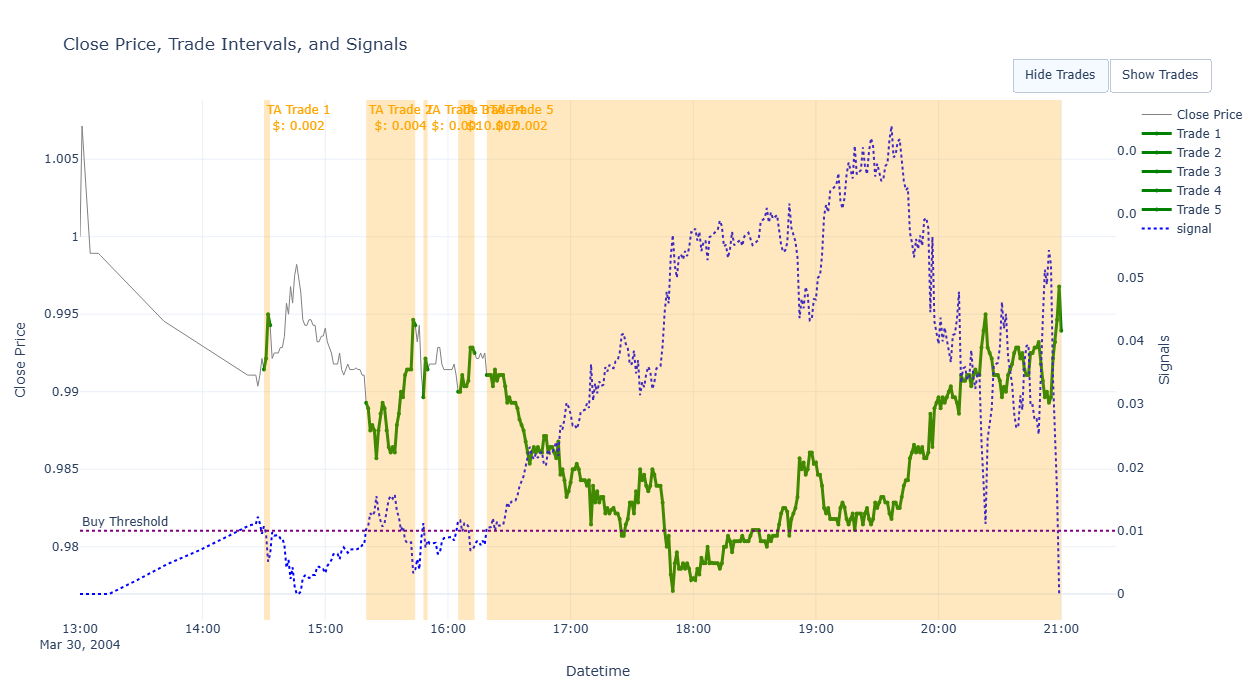


=== Performance for 2004-03-30 00:00:00 ===
Buy & Hold Return ($): 0.002
Strategy Return ($): 0.012
Trades Returns ($): [0.002, 0.004, 0.001, 0.002, 0.002]

=== Processing trading day 2004-03-31 ===

 Running trading pipeline on selected date …
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


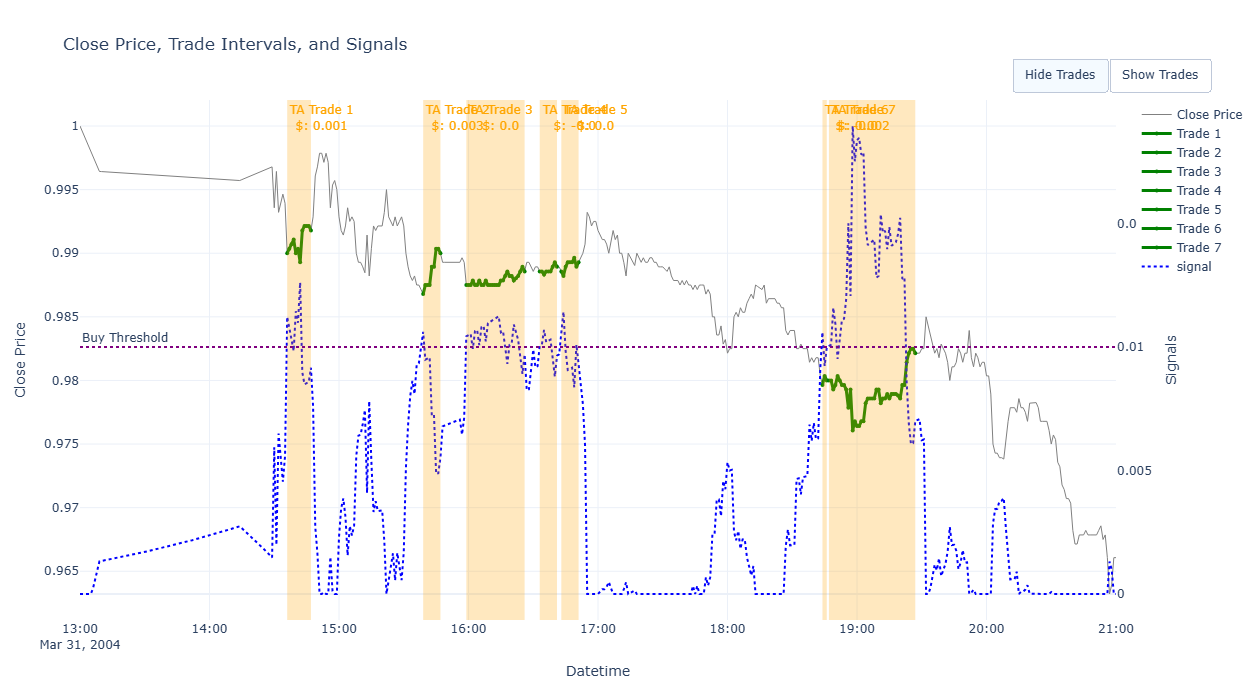


=== Performance for 2004-03-31 00:00:00 ===
Buy & Hold Return ($): -0.028
Strategy Return ($): 0.006
Trades Returns ($): [0.001, 0.003, 0.0, -0.0, 0.0, -0.0, 0.002]

Overall Summary (2004-03-01 = 0.8645 → 2004-03-31 = 0.9658)

One-time buy&hold gain: 0.101
Buy & Hold – each day ($): 0.114
Strategy Return ($): 0.516
Trades Count: 98
Strategy return per trade: 0.005
Num. trading days: 23
Strategy return per trading day: 0.022


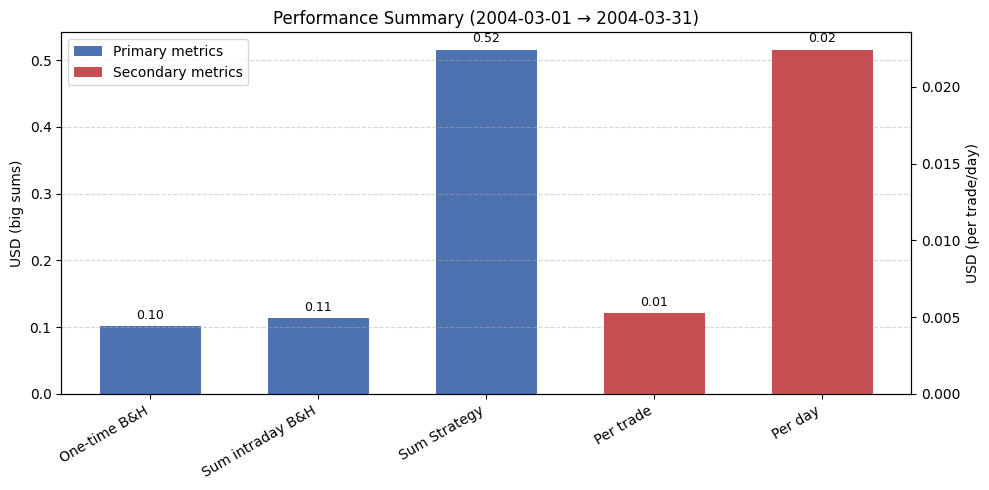

open      high       low     close     volume  \
2004-03-01 11:30:00  0.854643  0.854643  0.854643  0.854643  1072400.0   
2004-03-01 11:31:00  0.854643  0.854643  0.854643  0.854643  1072400.0   
2004-03-01 11:32:00  0.854643  0.854643  0.854643  0.854643  1072400.0   
2004-03-01 11:33:00  0.854643  0.854643  0.854643  0.854643  1072400.0   
2004-03-01 11:34:00  0.854643  0.854643  0.854643  0.854643  1072400.0   
...                       ...       ...       ...       ...        ...   
2004-03-31 20:56:00  0.967857  0.968214  0.966071  0.966071  1389668.0   
2004-03-31 20:57:00  0.966071  0.966429  0.963214  0.963214  4104240.0   
2004-03-31 20:58:00  0.963214  0.965000  0.962500  0.963929  4505508.0   
2004-03-31 20:59:00  0.964643  0.966071  0.962857  0.966071  6420372.0   
2004-03-31 21:00:00  0.966071  0.966429  0.965000  0.966071  8148560.0   

                          ask       bid    signal  signal_action  Position  \
2004-03-01 11:30:00  0.854900  0.854386  0.035664              0         0   
2004-03-01 11:31:00  0.854900  0.854386  0.035843              0         0   
2004-03-01 11:32:00  0.854900  0.854386  0.036022              0         0   
2004-03-01 11:33:00  0.854900  0.854386  0.036203              0         0   
2004-03-01 11:34:00  0.854900  0.854386  0.036384              0         0   
...                       ...       ...       ...            ...       ...   
2004-03-31 20:56:00  0.966361  0.965782  0.000000              0         0   
2004-03-31 20:57:00  0.963504  0.962925  0.001312              0         0   
2004-03-31 20:58:00  0.964218  0.963639  0.000989              0         0   
2004-03-31 20:59:00  0.966361  0.965782  0.000000              0         0   
2004-03-31 21:00:00  0.966361  0.965782  0.000000              0         0   

                      Cash  NetValue    Action  TradedAmount  BuyHoldEarning  \
2004-03-01 11:30:00  0.000     0.000  No trade             0           0.000   
2004-03-01 11:31:00  0.000     0.000  No trade             0           0.000   
2004-03-01 11:32:00  0.000     0.000  No trade             0           0.000   
2004-03-01 11:33:00  0.000     0.000  No trade             0           0.000   
2004-03-01 11:34:00  0.000     0.000  No trade             0           0.000   
...                    ...       ...       ...           ...             ...   
2004-03-31 20:56:00  0.006     0.006      Hold             0          -0.028   
2004-03-31 20:57:00  0.006     0.006      Hold             0          -0.031   
2004-03-31 20:58:00  0.006     0.006      Hold             0          -0.030   
2004-03-31 20:59:00  0.006     0.006      Hold             0          -0.028   
2004-03-31 21:00:00  0.006     0.006  No trade             0          -0.028   

                     StrategyEarning  EarningDiff  
2004-03-01 11:30:00            0.000        0.000  
2004-03-01 11:31:00            0.000        0.000  
2004-03-01 11:32:00            0.000        0.000  
2004-03-01 11:33:00            0.000        0.000  
2004-03-01 11:34:00            0.000        0.000  
...                              ...          ...  
2004-03-31 20:56:00            0.006        0.034  
2004-03-31 20:57:00            0.006        0.037  
2004-03-31 20:58:00            0.006        0.036  
2004-03-31 20:59:00            0.006        0.034  
2004-03-31 21:00:00            0.006        0.034  

[13133 rows x 17 columns]

In [6]:
df_fin = saveDF_checkDAY(
                        df=df,
                        ticker=params.ticker,
                        min_prof_thr=params.min_prof_thr_tick, 
                        max_down_prop=params.max_down_prop_tick, 
                        gain_tightening_factor=params.gain_tightening_factor_tick,
                        smooth_win_sig=params.smooth_win_sig_tick, 
                        pre_entry_decay=params.pre_entry_decay_tick, 
                        buy_threshold=params.buy_threshold_tick, 
                        trailing_stop_thresh=params.trailing_stop_thresh_tick,
                        merging_retracement_thr=params.merging_retracement_thr_tick, 
                        merging_time_gap_thr=params.merging_time_gap_thr_tick,
                        date_to_check=params.date_to_check
                        )

df_fin


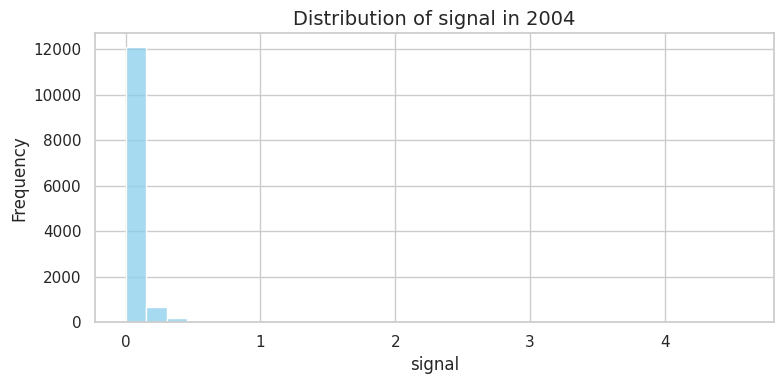

signal_min  signal_max  signal_mean  signal_median  close_return
2004-03         0.0    4.582352     0.081551        0.01656      0.196335

In [7]:
# Group by month
period = df_fin.index.to_period('M')

# Monthly stats for signal
signal_stats = df_fin.groupby(period)['signal'].agg(
    signal_min='min',
    signal_max='max',
    signal_mean='mean',
    signal_median='median'
)

# Monthly close return: (max - min) / min
close_return = df_fin.groupby(period)['close'].agg(
    close_return=lambda x: np.nan if x.min() == 0 else (x.max() - x.min()) / x.min()
)

# Combine into one DataFrame
monthly_stats = signal_stats.join(close_return)


# --------------------------------------------------
# Now plot histograms of signal for each year
# --------------------------------------------------

sns.set(style="whitegrid")
unique_years = sorted(df_fin.index.year.unique())

for y in unique_years:
    subset = df_fin[df_fin.index.year == y]['signal']
    
    plt.figure(figsize=(8, 4))
    sns.histplot(subset, bins=30, kde=False, color="skyblue")
    plt.title(f"Distribution of signal in {y}", fontsize=14)
    plt.xlabel("signal", fontsize=12)
    plt.ylabel("Frequency", fontsize=12)
    plt.tight_layout()
    plt.show()

monthly_stats


In [8]:
if date_to_check == None:
    
    # 1) Ensure the index is datetime
    df_fin.index = pd.to_datetime(df_fin.index)
    
    # 2) Filter to that month
    mask_month = df_fin.index.strftime("%Y-%m") == month_to_plot
    df_month  = df_fin.loc[mask_month]
    
    # 3) Group by calendar day
    groups = df_month.groupby(df_month.index.normalize(), sort=True)
    
    # 4) Loop over each day and make a dual-axis plot
    for day_date, df_day in groups:
        day_str = day_date.strftime("%Y-%m-%d")
        if df_day.empty:
            continue
    
        fig, ax1 = plt.subplots(figsize=(10, 4))
    
        # Plot signal on the left y-axis
        ax1.plot(
            df_day.index, df_day["signal"],
            color="tab:blue", lw=1.5, label="signal"
        )
        ax1.set_xlabel("Time")
        ax1.set_ylabel("Signal Value")
        ax1.tick_params(axis="y", labelcolor="black")
    
        # Plot close price on the right y-axis
        ax2 = ax1.twinx()
        ax2.plot(
            df_day.index, df_day["close"],
            color="tab:green", lw=1.0, label="close"
        )
        ax2.set_ylabel("Close Price", color="tab:green")
        ax2.tick_params(axis="y", labelcolor="tab:green")
    
        # Combine legends from both axes
        lines1, labels1 = ax1.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        ax1.legend(lines1 + lines2, labels1 + labels2, loc="upper left")
    
        plt.title(f"Signals & Close Price on {day_str}")
        ax1.xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter("%H:%M"))
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
